In [11]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors

def calculate_fp(molecule, method='maccs'):
    # Calculate the fingerprint of a molecule.
    return rdMolDescriptors.GetMorganFingerprintAsBitVect(molecule,  radius=2, nBits=2048)

def to_fingerprint(data_df, fp_name, verbose=False):
    """
    Calculate the specified fingerprint for each molecule in the DataFrame.
    Args:
        df: Pandas DataFrame containing 'smiles' column.
        fp_name: Name of the fingerprint method to use.
        verbose: If True, print status messages during execution.
    Returns:
        Modified DataFrame with the calculated fingerprint column.
    """
    df_fp = data_df.copy()
    if verbose:
        print('> Constructing a molecule from SMILES and Creating fingerprints')
    df_fp['molecule'] = df_fp.smile.map(lambda smile: Chem.MolFromSmiles(smile))
    df_fp[fp_name] = df_fp.molecule.apply(calculate_fp, args=[fp_name])
    # df_fp = df_fp.drop(['smile'], axis=1)
    return df_fp



In [12]:
import numpy as np

def decode_fingerprints(data_df):
    # Decode fingerprints stored in DataFrame into a numerical format.
    decoded_fingerprints = []
    for fp in data_df['morgan2_c']:
        arr = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        decoded_fingerprints.append(arr)
    return np.array(decoded_fingerprints)

In [13]:
def generate_individual_row_images_text_above(df, output_folder='row_images',
                                              columns_to_show=['smile', 'Activity_type'],
                                              mol_col='molecule',
                                              img_size=(600, 600), font_size=18):
    from rdkit.Chem import Draw
    from PIL import Image, ImageDraw, ImageFont
    import os

    os.makedirs(output_folder, exist_ok=True)
    df = df.copy()

    try:
        font_path = "/Library/Fonts/Arial Unicode.ttf"  # For macOS
        font = ImageFont.truetype(font_path, font_size)
    except:
        print("⚠️ Falling back to default font. Consider setting font_path manually.")
        font = ImageFont.load_default()

    for idx, row in df.iterrows():
        mol = row[mol_col]
        mol_img = Draw.MolToImage(mol, size=img_size) if mol else Image.new("RGB", img_size, "white")

        # Prepare text lines (e.g., SMILES + Activity_type)
        text_lines = [f"{col}: {str(row[col])}" for col in columns_to_show]

        # Measure text height and width
        dummy_img = Image.new("RGB", (10, 10))
        dummy_draw = ImageDraw.Draw(dummy_img)
        text_width = max([dummy_draw.textbbox((0, 0), line, font=font)[2] for line in text_lines]) + 40
        text_height = sum([dummy_draw.textbbox((0, 0), line, font=font)[3] - dummy_draw.textbbox((0, 0), line, font=font)[1] for line in text_lines]) + 60

        # Create text image
        text_img = Image.new("RGB", (max(text_width, img_size[0]), text_height), "white")
        draw = ImageDraw.Draw(text_img)
        y_offset = 20
        for line in text_lines:
            draw.text((20, y_offset), line, fill="black", font=font)
            y_offset += font_size + 10

        # Combine text on top, molecule below
        total_width = max(text_img.width, mol_img.width)
        total_height = text_img.height + mol_img.height
        combined = Image.new("RGB", (total_width, total_height), "white")
        combined.paste(text_img, (0, 0))
        combined.paste(mol_img, (0, text_img.height))

        # Save to file
        fname = f"row_{idx}.png"
        combined.save(os.path.join(output_folder, fname))

    print(f"✅ Saved {len(df)} images (text on top) to folder: {output_folder}")


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_parameters(study,protein_name, metrics):   
    # Convert best parameters to DataFrame
    params_df = pd.DataFrame.from_dict(study.params, orient='index', columns=['Value'])
    params_df.index.name = 'XGBoost Parameters'
    params_df.reset_index(inplace=True)

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(8, len(params_df)*0.6))  # Auto-adjust height

    # Hide axes
    ax.axis('off')

    # Create table
    table = ax.table(
        cellText=params_df.values,
        colLabels=params_df.columns,
        cellLoc='center',
        loc='center'
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(0.8, 3)

    # Color header
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#fbeec1')  # Light yellow for header
        else:
            cell.set_facecolor('#dff6fd')  # Light blue rows

    # Save as PNG
    plt.savefig(f'./output/Proteins/{protein_name}/{protein_name}_{metrics}/best_xgboost_params.png', dpi=300, bbox_inches='tight')
    plt.show()


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_combined_roc(y_train, train_probs, y_test, test_probs,protein_name, metrics):
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)

    auc_train = roc_auc_score(y_train, train_probs)
    auc_test = roc_auc_score(y_test, test_probs)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, color="#74aee5", label=f'AUC_train = {auc_train:.3f}')
    plt.plot(fpr_test, tpr_test, color="#e27120", label=f'AUC_test = {auc_test:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')

    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(f'./output/Proteins/{protein_name}/{protein_name}_{metrics}/roc_curve_combined.png', dpi=300, bbox_inches='tight')
    plt.show()



In [16]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def plot_combined_calibration(y_train, train_probs, y_test, test_probs, protein_name, metrics):
    # Compute calibration curves
    prob_true_train, prob_pred_train = calibration_curve(y_train, train_probs)
    prob_true_test, prob_pred_test = calibration_curve(y_test, test_probs)

    # Compute Brier scores
    brier_train = brier_score_loss(y_train, train_probs)
    brier_test = brier_score_loss(y_test, test_probs)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.plot(prob_pred_train, prob_true_train, color="#74aee5", label=f"train: {brier_train:.4f}")
    plt.plot(prob_pred_test, prob_true_test, color="#e27120", label=f"test: {brier_test:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='perfectly_calibrated')

    plt.title('Calibration curve')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Save and show
    plt.savefig(f'./output/Proteins/{protein_name}/{protein_name}_{metrics}/calibration_curve_combined.png', dpi=300, bbox_inches='tight')
    plt.show()


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred, protein_name, metrics,labels=None):
    # Standard confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot standard
    disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_title("Confusion Matrix")

    # Plot normalized
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
    disp_norm.plot(cmap='Blues', ax=ax[1], colorbar=False, values_format='.2f')
    ax[1].set_title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f'./output/Proteins/{protein_name}/{protein_name}_{metrics}/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()





In [18]:
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def compute_metrics_table(y_true_train, y_pred_train, y_prob_train,
                          y_true_test, y_pred_test, y_prob_test):
    
    def compute_all(y_true, y_pred, y_prob):
        auc = roc_auc_score(y_true, y_prob)
        acc = accuracy_score(y_true, y_pred)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp)
        
        return {
            'AUC': auc,
            'Accuracy': acc,
            'Balanced Accuracy': bal_acc,
            'Specificity': spec,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1
        }

    train_metrics = compute_all(y_true_train, y_pred_train, y_prob_train)
    test_metrics = compute_all(y_true_test, y_pred_test, y_prob_test)

    df = pd.DataFrame({
        'Train': train_metrics,
        'Test': test_metrics
    })

    # Display table
    print("\n📊 Metrics Summary:")
    print(df.round(4))
    return df



In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_table(metrics_df,protein_name, metrics):
    fig, ax = plt.subplots(figsize=(8, metrics_df.shape[0]*0.6+1))  # Adjust height dynamically
    ax.axis('off')

    # Create table
    table = ax.table(
        cellText=metrics_df.round(4).values,
        colLabels=metrics_df.columns,
        rowLabels=metrics_df.index,
        cellLoc='center',
        loc='center'
    )

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(0.8, 3)

    # Header color
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#fbeec1')  # Light yellow for column headers
        elif col == -1:  # row labels (metric names)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#dff6fd')  # Light blue for row headers
        else:
            cell.set_facecolor('#f0f0f0')  # Light gray for cells

    plt.title('Model Performance Metrics', fontsize=14, weight='bold')
    plt.savefig(f'./output/Proteins/{protein_name}/{protein_name}_{metrics}/metrics_summary.png', dpi=300, bbox_inches='tight')
    plt.show()




In [54]:
import matplotlib.pyplot as plt
import numpy as np
import optuna

def plot_pareto_front_balanced_accuracy(study, protein_name,best_trial,metrics,x_key='test_balanced_accuracy', y_key='gap_balanced_accuracy'):
    trials = [t for t in study.trials if t.values is not None]
    x = [t.values[0] for t in trials]  # Balanced Accuracy (test)
    y = [t.values[1] for t in trials]  # Gap (train - test)

    x = np.array(x)
    y = np.array(y)

    # Find Pareto front
    def is_pareto_efficient(costs):
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
                is_efficient[i] = True
        return is_efficient

    costs = np.column_stack([-x, y])  # max x (test accuracy), min y (gap)
    is_efficient = is_pareto_efficient(costs)
    pareto_x = x[is_efficient]
    pareto_y = y[is_efficient]

    best_trial_idx = best_trial.number
    best_x = best_trial.values[0]
    best_y = best_trial.values[1]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, color='cornflowerblue', alpha=0.7, label='Trials')
    plt.scatter(pareto_x, pareto_y, color='orchid', label='Pareto Front Trials')
    plt.scatter(best_x, best_y, color='purple', edgecolor='black', s=100, label=f'Best Trial (# {best_trial_idx})')

    plt.title("Pareto Chart with Highlighted Best Attempt")
    plt.xlabel("Score balanced_accuracy (Test)")
    plt.ylabel("Difference in Train-Test balanced_accuracy")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(f'./output/Proteins/{protein_name}/{protein_name}_{metrics}/best_pareto_chart.png', dpi=300, bbox_inches='tight')
    plt.show()


In [21]:
import os

def save_xgb_model(model, folder_path, file_name="xgboost_model.json"):
    """
    Save the XGBoost model to a specified folder.

    Parameters:
    - model: trained XGBoost model (XGBClassifier or Booster)
    - folder_path: string, path to folder where model will be saved
    - file_name: string, name of the model file (default: xgboost_model.json)

    Returns:
    - Full file path where model is saved
    """
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    # Full file path
    file_path = os.path.join(folder_path, file_name)

    # Save the model
    model.save_model(file_path)

    print(f"✅ Model saved to: {file_path}")
    return file_path

# Example usage after training
# Assume: model = trained XGBClassifier



In [22]:
def ligand_distribution_plot(Y_train,protein_name):
    # Count active and inactive ligands in Y_train (after encoding: 0=Inactive, 1=Active)
    ligand_counts = Y_train.value_counts()

    # Define correct label mapping
    label_names = {0: 'Inactive', 1: 'Active'}
    ordered_labels = [0, 1]  # Integer labels for order
    ordered_counts = [ligand_counts[label] for label in ordered_labels]

    # Define custom colors for labels
    colors = {
        'Active': "#74aee5",     # Blue
        'Inactive': "#f36607"    # Orange
    }

    # Create the bar plot
    plt.figure(figsize=(7, 12))
    bars = plt.bar(
        [label_names[l] for l in ordered_labels],  # Convert to 'Inactive', 'Active'
        ordered_counts,
        color=[colors[label_names[l]] for l in ordered_labels]
    )

    # Add count labels above the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height - 4 ,  # Inside the bar
            f'{int(height)}', ha='center', va='top',
            color='black', fontsize=12
        )

    plt.title('Ligand Distribution')
    plt.xlabel('Ligand Type')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(f'./output/Proteins/{protein_name}/ligand_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
import graphviz
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

csv_path = './Dataset/O00519_CHEMBL2243.csv'
df = pd.read_csv(csv_path)
df = df.rename(columns={'canonical_smiles (Canonical)': 'smile'})
file_name = os.path.basename(csv_path) 
protein_name = file_name.split('_')[0]
print("Protein Name:", protein_name)

if not os.path.exists(f'./output/Proteins/{protein_name}'):
    os.makedirs(f'./output/Proteins/{protein_name}')
if not os.path.exists('./output/Trained_Models'):
    os.makedirs('./output/Trained_Models')
    
for x in df.index:
    if df.loc[x, 'Activity_type'] == "Intermediate":
        df.drop(x,inplace=True)

# display(df)
print(df.shape)


Protein Name: O00519
(1263, 27)


[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerator
[08:52:17] DEPRECATION WARNING: please use MorganGenerat

(1263, 2048)

1607

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1010, 2048))

32      1
156     1
382     1
1511    0
365     1
       ..
1389    0
1440    0
1475    0
1205    0
1471    0
Name: Activity_type, Length: 1010, dtype: int64

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(253, 2048))

1552    0
1213    0
532     1
344     1
405     1
       ..
163     1
485     1
679     1
221     1
243     1
Name: Activity_type, Length: 253, dtype: int64

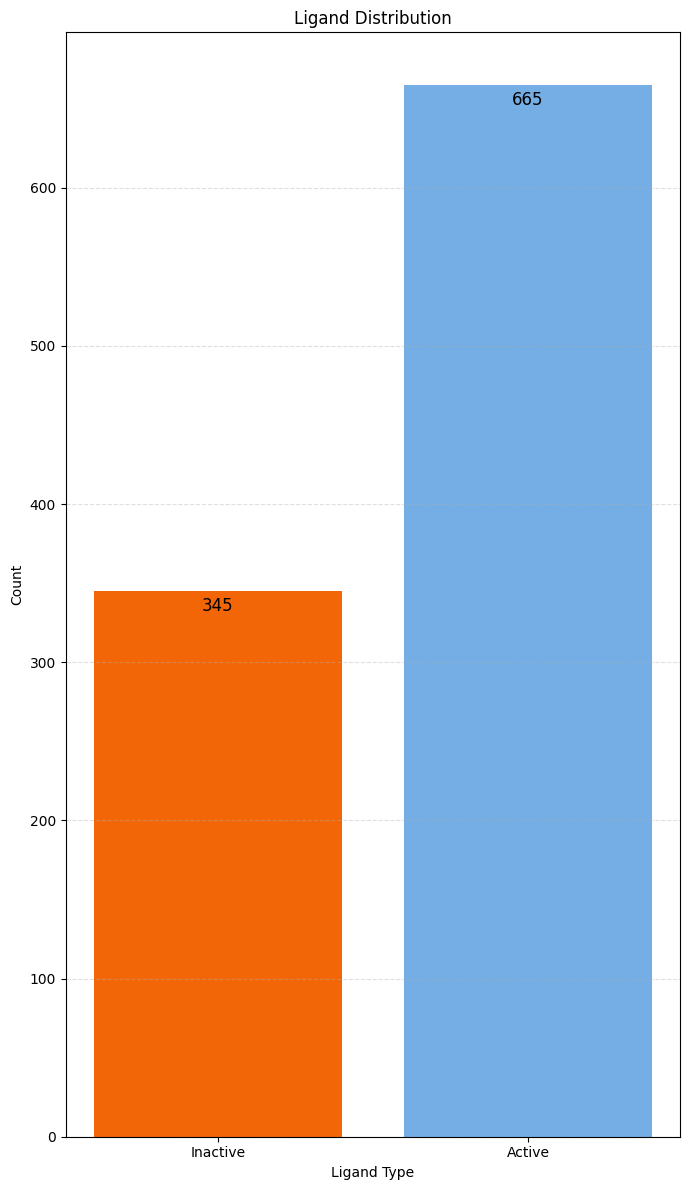

In [24]:

df_fingerprints = to_fingerprint(df, 'morgan2_c')
df_fingerprints.to_csv('./fingerprints.csv', index=False) 
# generate_individual_row_images_text_above(  
#     df_fingerprints,output_folder='row_images_toptext', 
#     columns_to_show=['smile', 'Activity_type'],
#     img_size=(600, 600),
#     font_size=24
# )
df_fingerprints = decode_fingerprints(df_fingerprints)
display(df_fingerprints.shape)
display(x)
# df_fingerprints.to_csv('./fingerprints.csv', index=False) 
# display(df_fingerprints)
x=df_fingerprints
y = df['Activity_type'].map({'Inactive': 0, 'Active': 1})
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
display(X_train, Y_train)
display(X_test, Y_test)

ligand_distribution_plot(Y_train,protein_name)

In [25]:
import optuna
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score
import warnings

# ✅ Suppress logs from trials (this removes the multiline output)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optional: suppress UserWarnings from XGBoost
warnings.filterwarnings("ignore", category=UserWarning)

# Objective function
def objective(trial):
    global X_train, Y_train, X_test, Y_test
    param = {
    'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),  # L1 regularization
    'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),  # L2 regularization
    'max_depth': trial.suggest_int('max_depth', 3, 12),  # Deep trees tend to overfit
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Log scale for precision
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),  # Usually 100–1000 is enough
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Row sampling
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature sampling
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Larger helps avoid overfitting
    'gamma': trial.suggest_float('gamma', 0.0, 5.0),  # Minimum loss reduction required to split
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 penalty (again)
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),  # L2 penalty
    'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0)  # Useful in imbalanced datasets
    }

    model = xgb.XGBClassifier(
        **param,
        tree_method='hist',
        device='cpu',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42  # For reproducibility
    )

    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    score = balanced_accuracy_score(Y_test, preds)
    return score




In [26]:
# Create study
study = optuna.create_study(study_name="xgb_balanced_acc", direction='maximize')

# 🔄 Run optimization with a SINGLE PROGRESS BAR ABOVE all output
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# ✅ Final result after the bar
print("\nBest trial:")
print(f"Value (Balanced Accuracy): {study.best_value:.4f}")
print("Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k:20}: {v}")


  0%|          | 0/1000 [00:00<?, ?it/s]

[W 2025-06-26 08:52:23,308] Trial 8 failed with parameters: {'alpha': 0.09494476972419388, 'lambda': 1.6403388786020924e-07, 'max_depth': 9, 'learning_rate': 0.020694185301781517, 'n_estimators': 350, 'subsample': 0.5523943979773167, 'colsample_bytree': 0.9478318280113684, 'min_child_weight': 8, 'gamma': 1.1690140065566113, 'reg_alpha': 1.5413068387087693e-08, 'reg_lambda': 2.0635932246833114e-07, 'scale_pos_weight': 6.910028305546082} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/5m/01t1b79n1kl_5qvb6c1v86l80000gn/T/ipykernel_22403/1756287219.py", line 39, in objective
    model.fit(X_train, Y_train)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py", line 729, in inne

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
model = xgb.XGBClassifier(
    **study.best_params,
    tree_method='hist',
    device='cpu',
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)
model.fit(X_train, Y_train)

train_probs = model.predict_proba(X_train)[:, 1]
train_preds = model.predict(X_train)
test_probs = model.predict_proba(X_test)[:, 1]
test_preds = model.predict(X_test)

if not os.path.exists(f'./output/Proteins/{protein_name}/{protein_name}_balanced_accuracy'):
    os.makedirs(f'./output/Proteins/{protein_name}/{protein_name}_balanced_accuracy')

plot_parameters(study,protein_name, "balanced_accuracy")
plot_combined_calibration(Y_train, train_probs, Y_test, test_probs,protein_name, "balanced_accuracy")
plot_combined_roc(Y_train, train_probs, Y_test, test_probs,protein_name, "balanced_accuracy")
plot_confusion_matrices(Y_test, test_preds,protein_name, "balanced_accuracy")
metrics_df = compute_metrics_table(Y_train, train_preds, train_probs, Y_test, test_preds, test_probs)
plot_metrics_table(metrics_df,protein_name, "balanced_accuracy")
save_xgb_model(model, folder_path="./output/Trained_models", file_name=f"{protein_name}_balanced_accuracy.json")

In [ ]:
tree_dot = xgb.to_graphviz(model)
dot_file_path = f'./output/{protein_name}/{protein_name}_balanced_accuracy/xgboost_tree.dot'
tree_dot.save(dot_file_path)
with open(dot_file_path) as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render("xgboost_tree")
graph

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score
import warnings

# ✅ Suppress logs from trials (this removes the multiline output)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optional: suppress UserWarnings from XGBoost
warnings.filterwarnings("ignore", category=UserWarning)

# Objective function
def objective2(trial):
    global X_train, Y_train, X_test, Y_test
    param = {
    'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),  # L1 regularization
    'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),  # L2 regularization
    'max_depth': trial.suggest_int('max_depth', 3, 12),  # Deep trees tend to overfit
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Log scale for precision
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),  # Usually 100–1000 is enough
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Row sampling
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature sampling
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Larger helps avoid overfitting
    'gamma': trial.suggest_float('gamma', 0.0, 5.0),  # Minimum loss reduction required to split
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 penalty (again)
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),  # L2 penalty
    'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0)  # Useful in imbalanced datasets
}

    model = xgb.XGBClassifier(
        **param,
        tree_method='hist',
        device='cpu',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42  # For reproducibility
    )

    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    # Use F1 score instead of balanced_accuracy_score
    score = f1_score(Y_test, preds, average='macro')  # or 'weighted' / 'binary'
    return score

In [ ]:
study2 = optuna.create_study(study_name="xgb_auc", direction='maximize')
study2.optimize(objective2, n_trials=1000, show_progress_bar=True)

# ✅ Final result after the bar
print("\nBest trial:")
print(f"Value (f1): {study2.best_value:.4f}")
print("Best Parameters:")
for k, v in study2.best_params.items():
    print(f"{k:20}: {v}")


In [ ]:
best_params2 = study2.best_params
model2 = xgb.XGBClassifier(
    **study2.best_params,
    tree_method='hist',
    device='cpu',
    use_label_encoder=False,
    eval_metric='logloss',
)
model2.fit(X_train, Y_train)

train_probs = model2.predict_proba(X_train)[:, 1]
train_preds = model2.predict(X_train)
test_probs = model2.predict_proba(X_test)[:, 1]
test_preds = model2.predict(X_test)

if not os.path.exists(f'./output/Proteins/{protein_name}/{protein_name}_f1'):
    os.makedirs(f'./output/Proteins/{protein_name}/{protein_name}_f1')

plot_parameters(study,protein_name, "f1")
plot_combined_calibration(Y_train, train_probs, Y_test, test_probs,protein_name, "f1")
plot_combined_roc(Y_train, train_probs, Y_test, test_probs,protein_name, "f1")
plot_confusion_matrices(Y_test, test_preds,protein_name, "f1")
metrics_df = compute_metrics_table(Y_train, train_preds, train_probs, Y_test, test_preds, test_probs)
plot_metrics_table(metrics_df,protein_name, "f1")
save_xgb_model(model2, folder_path="./output/Trained_models", file_name=f"{protein_name}_f1.json")

In [ ]:
tree_dot = xgb.to_graphviz(model2)
dot_file_path = f'./output/{protein_name}/{protein_name}_f1/xgboost_tree.dot'
tree_dot.save(dot_file_path)
with open(dot_file_path) as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render("xgboost_tree")
graph

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import precision_score
import warnings

# ✅ Suppress logs from trials (this removes the multiline output)
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optional: suppress UserWarnings from XGBoost
# warnings.filterwarnings("ignore", category=UserWarning)

# Objective function
def objective3(trial):
    global X_train, Y_train, X_test, Y_test
    param = {
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),  # L1 regularization
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),  # L2 regularization
        'max_depth': trial.suggest_int('max_depth', 3, 12),  # Deep trees tend to overfit
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Log scale for precision
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),  # Usually 100–1000 is enough
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Row sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature sampling
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Larger helps avoid overfitting
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),  # Minimum loss reduction required to split
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 penalty (again)
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),  # L2 penalty
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0)  # Useful in imbalanced datasets
    }

    model = xgb.XGBClassifier(
        **param,
        tree_method='hist',
        device='cpu',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42  # For reproducibility
    )

    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    # Use precision instead of F1 or accuracy
    score = precision_score(Y_test, preds, average='macro')  # or 'weighted' or 'binary'
    return score

In [ ]:
study3 = optuna.create_study(study_name="xgb_precision", direction='maximize')
study3.optimize(objective3, n_trials=1000, show_progress_bar=True)

# ✅ Final result after the bar
print("\nBest trial:")
print(f"Value (Precision): {study.best_value:.4f}")
print("Best Parameters:")
for k, v in study3.best_params.items():
    print(f"{k:20}: {v}")


In [ ]:
best_params3 = study3.best_params
model3 = xgb.XGBClassifier(
    **study3.best_params,
    tree_method='hist',
    device='cpu',
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)
model3.fit(X_train, Y_train)

train_probs = model3.predict_proba(X_train)[:, 1]
train_preds = model3.predict(X_train)
test_probs = model3.predict_proba(X_test)[:, 1]
test_preds = model3.predict(X_test)

if not os.path.exists(f'./output/Proteins/{protein_name}/{protein_name}_precision'):
    os.makedirs(f'./output/Proteins/{protein_name}/{protein_name}_precision')

plot_parameters(study,protein_name, "precision")
plot_combined_calibration(Y_train, train_probs, Y_test, test_probs,protein_name, "precision")
plot_combined_roc(Y_train, train_probs, Y_test, test_probs,protein_name, "precision")
plot_confusion_matrices(Y_test, test_preds,protein_name, "precision")
metrics_df = compute_metrics_table(Y_train, train_preds, train_probs, Y_test, test_preds, test_probs)
plot_metrics_table(metrics_df,protein_name, "precision")
save_xgb_model(model3, folder_path="./output/Trained_models", file_name=f"{protein_name}_precision.json")

In [ ]:
tree_dot = xgb.to_graphviz(model3)
dot_file_path = f'./output/{protein_name}/{protein_name}_precision/xgboost_tree.dot'
tree_dot.save(dot_file_path)
with open(dot_file_path) as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render("xgboost_tree")
graph

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
import shap

explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
import shap

explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings

# ✅ Suppress logs and warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)

# Objective function (modified for cross-validation)
def objective4(trial):
    global X_train, Y_train  # Keeping your global variable approach
    
    param = {
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'tree_method': 'hist',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42
    }

    # Using 7-fold CV like in your paper instead of train-test split
    model = xgb.XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, Y_train, 
                           cv=cv, scoring='balanced_accuracy', n_jobs=-1)
    
    return scores.mean()  # Return average CV score


In [ ]:


# Create study (keeping your original setup)
study4 = optuna.create_study(
    study_name="xgb_cv_balanced_acc", 
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)  # For reproducibility
)
 # Now using your original X_train/

# 🔄 Run optimization with progress bar 
study4.optimize(objective4, n_trials=1000, show_progress_bar=True)

# ✅ Final results (unchanged format)
print("\nBest trial:")
print(f"Value (Balanced Accuracy): {study4.best_value:.4f}")
print("Best Parameters:")
for k, v in study4.best_params.items():
    print(f"{k:20}: {v}")



In [ ]:
best_params4 = study4.best_params
model4 = xgb.XGBClassifier(
    **study4.best_params,
    tree_method='hist',
    device='cpu',
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)
model4.fit(X_train, Y_train)

train_probs = model4.predict_proba(X_train)[:, 1]
train_preds = model4.predict(X_train)
test_probs = model4.predict_proba(X_test)[:, 1]
test_preds = model4.predict(X_test)

if not os.path.exists(f'./output/Proteins/{protein_name}/{protein_name}_cv_balanced_accuracy'):
    os.makedirs(f'./output/Proteins/{protein_name}/{protein_name}_cv_balanced_accuracy')

plot_parameters(study,protein_name, "cv_balanced_accuracy")
plot_combined_calibration(Y_train, train_probs, Y_test, test_probs,protein_name, "cv_balanced_accuracy")
plot_combined_roc(Y_train, train_probs, Y_test, test_probs,protein_name, "cv_balanced_accuracy")
plot_confusion_matrices(Y_test, test_preds,protein_name, "cv_balanced_accuracy")
metrics_df = compute_metrics_table(Y_train, train_preds, train_probs, Y_test, test_preds, test_probs)
plot_metrics_table(metrics_df,protein_name, "cv_balanced_accuracy")
save_xgb_model(model4, folder_path="./output/Trained_models", file_name=f"{protein_name}_cv_balanced_accuracy.json")

In [ ]:
import shap

explainer = shap.TreeExplainer(model4)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [27]:
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import warnings

# ✅ Suppress logs and warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)

def objective5_factory(X_train, Y_train):
        def objective5(trial):
            # global X_train, Y_train  # Assuming these are NumPy arrays or compatible

            param = {
                'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
                'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0.0, 5.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
                'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
                'tree_method': 'hist',
                'eval_metric': 'logloss',
                'use_label_encoder': False,
                'device': 'gpu', 
                'random_state': 42
            }
            # print(x.shape)
            # print(y.shape)
            model = xgb.XGBClassifier(**param)
            cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

            train_scores = []
            val_scores = []

            # ✅ Use local variable names to avoid overwriting x/y
            for train_idx, val_idx in cv.split(X_train, Y_train):
                X_tr = X_train[train_idx]
                X_val = X_train[val_idx]

                y_tr = Y_train.iloc[train_idx]
                y_val = Y_train.iloc[val_idx]

                model.fit(X_tr, y_tr)
                train_pred = model.predict(X_tr)
                val_pred = model.predict(X_val)

                train_scores.append(balanced_accuracy_score(y_tr, train_pred))
                val_scores.append(balanced_accuracy_score(y_val, val_pred))

            mean_train = np.mean(train_scores)
            mean_val = np.mean(val_scores)
            generalization_gap = abs(mean_train - mean_val)

            return mean_val, generalization_gap

        return objective5


In [28]:

study5 = optuna.create_study(
    directions=["maximize", "minimize"],  # val_bal_acc ↑, gap ↓
    study_name="xgb_cv_pareto_balanced_accuracy"
)
objective5 = objective5_factory(X_train, Y_train)

study5.optimize(objective5, n_trials=3000,show_progress_bar=True)


  0%|          | 0/3000 [00:00<?, ?it/s]

In [50]:
# def select_best_trial_from_pareto(study5, alpha=0.8):
#         # """Select best trial from Pareto front with weighted scoring"""
#         # pareto_trials = study.best_trials
        
#         # # Calculate weighted score for each trial (higher val_score and lower gap is better)
#         # scores = []
#         # for trial in pareto_trials:
#         #     weighted_score = alpha * trial.values[0] - (1 - alpha) * trial.values[1]
#         #     scores.append(weighted_score)
        
#         # best_idx = np.argmax(scores)
#         # return pareto_trials[best_idx]    
def select_best_pareto_highest_accuracy(study5):
    """
    Select the Pareto front trial with the highest validation balanced accuracy (val_score).
    """
    pareto_trials = study5.best_trials
    best_trial = max(pareto_trials, key=lambda t: t.values[1])  # values[1] = generalization gap
    return best_trial


# Select best trial from Pareto front
# best_trial = select_best_trial_from_pareto(study5)

# print("\nBest trial from Pareto front:")
# print(f"Validation Balanced Accuracy: {best_trial.values[0]:.4f}")
# print(f"Generalization Gap: {best_trial.values[1]:.4f}")
# print("Best Parameters:")
# for k, v in best_trial.params.items():
#     print(f"{k:20}: {v}")

best_trial = select_best_pareto_highest_accuracy(study5)

print(f"✅ Best Trial ID: #{best_trial.number}")
print(f"Balanced Accuracy (Validation): {best_trial.values[0]:.4f}")
print(f"Generalization Gap: {best_trial.values[1]:.4f}")
print("Best Hyperparameters:")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")



✅ Best Trial ID: #2840
Balanced Accuracy (Validation): 0.8524
Generalization Gap: 0.1082
Best Hyperparameters:
  alpha: 8.472035016350748
  lambda: 0.002965494536273122
  max_depth: 5
  learning_rate: 0.038227682307499365
  n_estimators: 1000
  subsample: 0.8302909825785819
  colsample_bytree: 0.9396641976775749
  min_child_weight: 1
  gamma: 1.052231401740662
  reg_alpha: 0.0014768067919523201
  reg_lambda: 0.453324351470424
  scale_pos_weight: 1.1940522192744045


In [2]:
# best_params5 = study5.best_params
model5 = xgb.XGBClassifier(
        **best_trial.params,
        tree_method='hist',
        device='gpu', 
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
model5.fit(X_train, Y_train)

train_probs = model5.predict_proba(X_train)[:, 1]
train_preds = model5.predict(X_train)
test_probs = model5.predict_proba(X_test)[:, 1]
test_preds = model5.predict(X_test)

if not os.path.exists(f'./output/Proteins/{protein_name}/{protein_name}_pareto_cv_balanced_accuracy'):
    os.makedirs(f'./output/Proteins/{protein_name}/{protein_name}_pareto_cv_balanced_accuracy')

plot_parameters(best_trial,protein_name, "pareto_cv_balanced_accuracy")
plot_combined_calibration(Y_train, train_probs, Y_test, test_probs,protein_name, "pareto_cv_balanced_accuracy")
plot_combined_roc(Y_train, train_probs, Y_test, test_probs,protein_name, "pareto_cv_balanced_accuracy")
plot_confusion_matrices(Y_test, test_preds,protein_name, "pareto_cv_balanced_accuracy")
metrics_df = compute_metrics_table(Y_train, train_preds, train_probs, Y_test, test_preds, test_probs)
plot_metrics_table(metrics_df,protein_name, "pareto_cv_balanced_accuracy")
plot_pareto_front_balanced_accuracy(study5, protein_name, best_trial,metrics="pareto_cv_balanced_accuracy")
save_xgb_model(model5, folder_path="./output/Trained_models", file_name=f"{protein_name}_pareto_cv_balanced_accuracy.json")


NameError: name 'xgb' is not defined

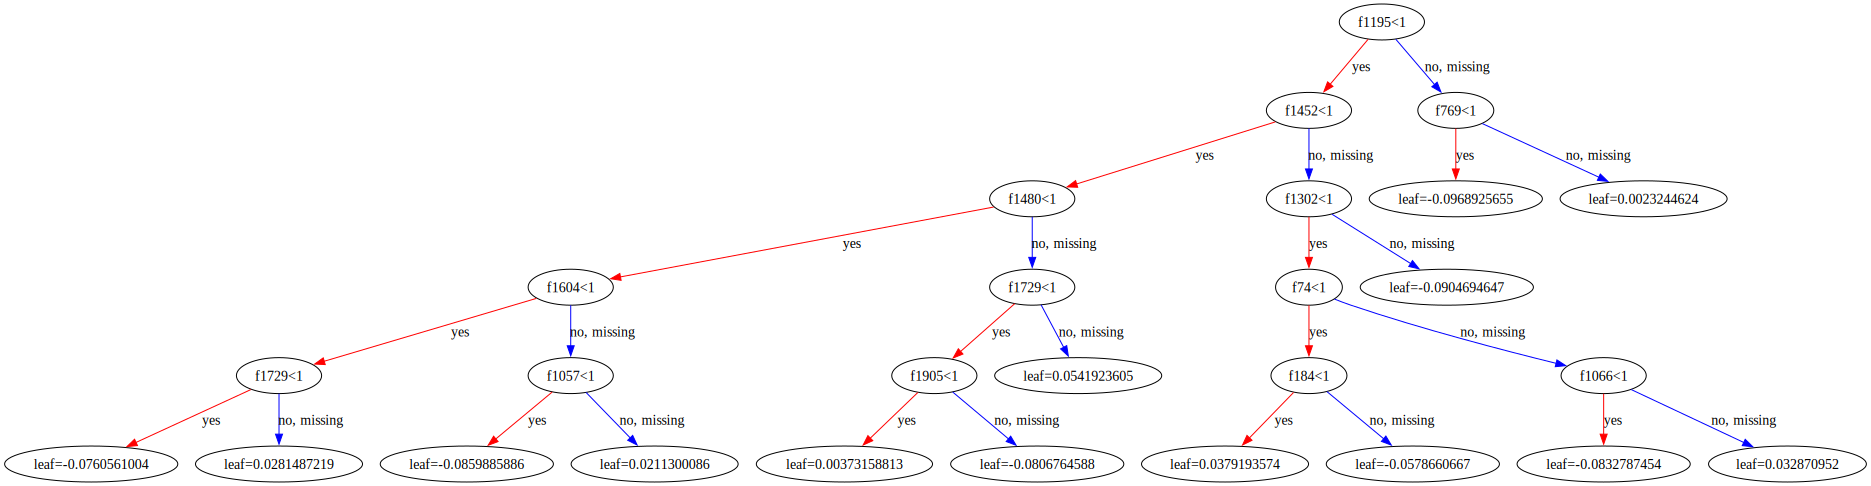

In [31]:
tree_dot = xgb.to_graphviz(model5)
dot_file_path = f'./output/Proteins/{protein_name}/{protein_name}_pareto_cv_balaced_accuracy/xgboost_tree.dot'
tree_dot.save(dot_file_path)
with open(dot_file_path) as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render("xgboost_tree")
graph

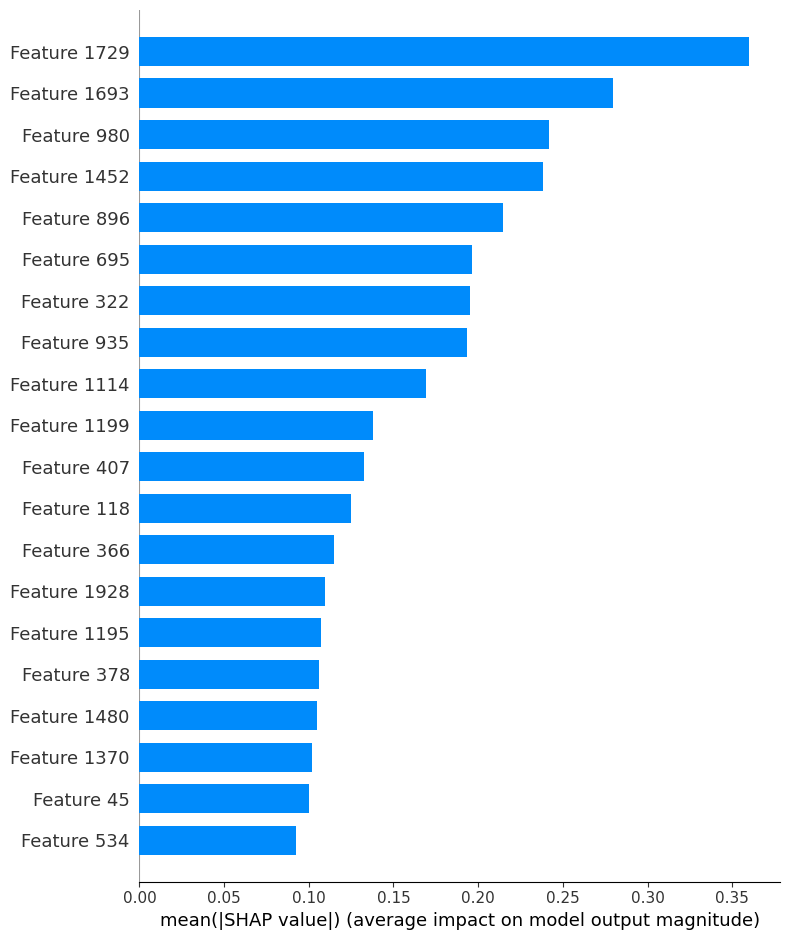

In [32]:
import shap

explainer = shap.TreeExplainer(model5)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [61]:
shap_mean = np.abs(shap_values).mean(axis=0)
top_bits = np.argsort(shap_mean)[-20:][::-1] 

In [62]:
from rdkit.Chem import AllChem

def generate_bitinfo_mapping(df, radius=2, nBits=2048):
    """
    Generate a mapping from fingerprint bits to substructure information.
    Returns:
        bit_info_map: dict of bit -> list of (mol, atom_idx, radius)
    """
    bit_info_map = {}
    for _, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smile'])
        if mol is None:
            continue
        info = {}
        _ = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=info)
        for bit, atom_info in info.items():
            for atom_idx, rad in atom_info:
                bit_info_map.setdefault(bit, []).append((mol, atom_idx, rad))
    return bit_info_map

In [63]:
from rdkit.Chem import Draw

def draw_bit_substructure(bit_id, bit_info_map):
    if bit_id not in bit_info_map:
        print(f"⚠️ No substructure info found for bit {bit_id}")
        return None
    mol, atom_idx, radius = bit_info_map[bit_id][0]  # Just take first occurrence
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
    amap = {}
    submol = Chem.PathToSubmol(mol, env, atomMap=amap)
    return Draw.MolToImage(submol, size=(300, 300))


Bit: 1729 — Mean SHAP: 0.3602


[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerator
[15:57:26] DEPRECATION WARNING: please use MorganGenerat

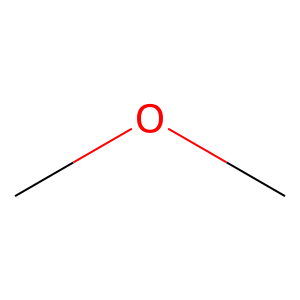

Bit: 1693 — Mean SHAP: 0.2798


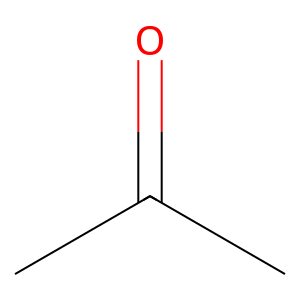

Bit: 980 — Mean SHAP: 0.2419


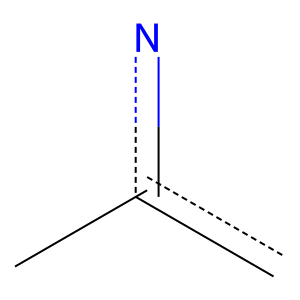

Bit: 1452 — Mean SHAP: 0.2381


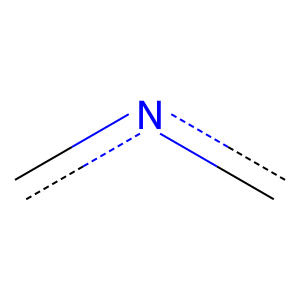

Bit: 896 — Mean SHAP: 0.2145


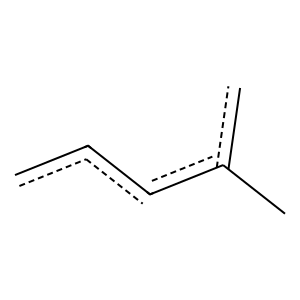

Bit: 695 — Mean SHAP: 0.1961


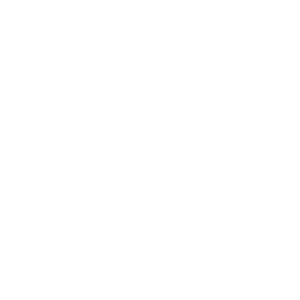

Bit: 322 — Mean SHAP: 0.1952


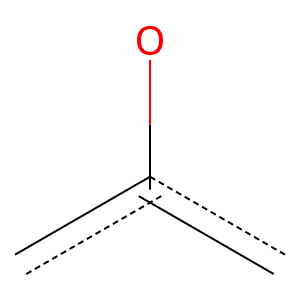

Bit: 935 — Mean SHAP: 0.1933


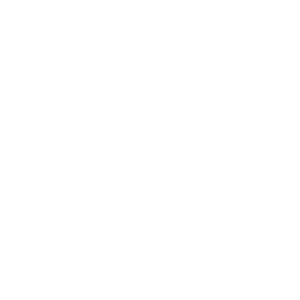

Bit: 1114 — Mean SHAP: 0.1695


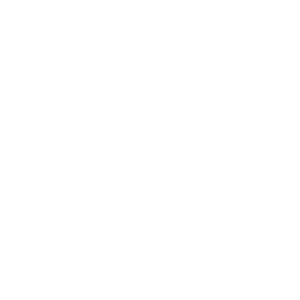

Bit: 1199 — Mean SHAP: 0.1381


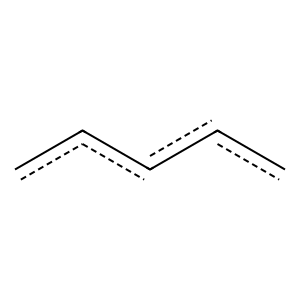

Bit: 407 — Mean SHAP: 0.1327


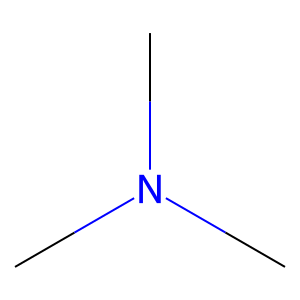

Bit: 118 — Mean SHAP: 0.1249


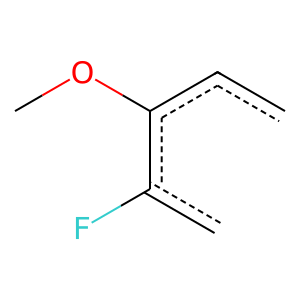

Bit: 366 — Mean SHAP: 0.1150


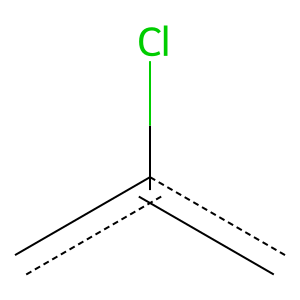

Bit: 1928 — Mean SHAP: 0.1094


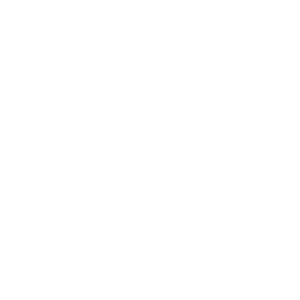

Bit: 1195 — Mean SHAP: 0.1069


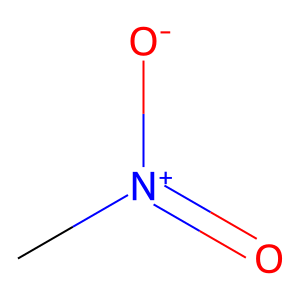

Bit: 378 — Mean SHAP: 0.1063


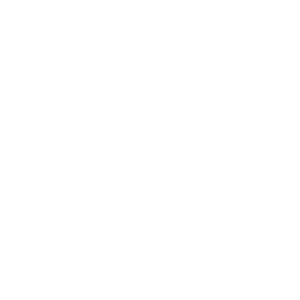

Bit: 1480 — Mean SHAP: 0.1050


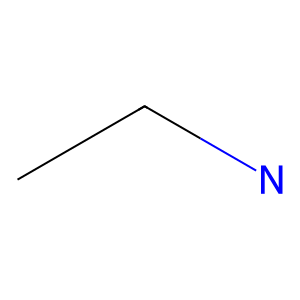

Bit: 1370 — Mean SHAP: 0.1017


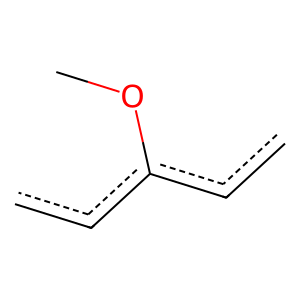

Bit: 45 — Mean SHAP: 0.1001


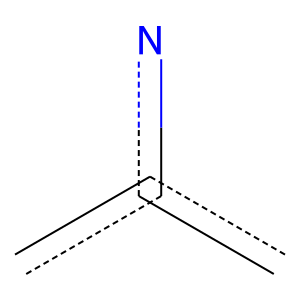

Bit: 534 — Mean SHAP: 0.0925


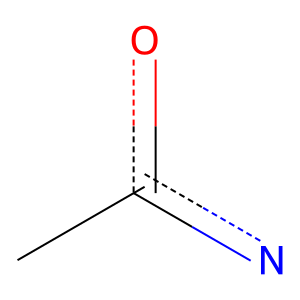

In [64]:
bit_info_map = generate_bitinfo_mapping(df)

for bit_id in top_bits:
    print(f"Bit: {bit_id} — Mean SHAP: {shap_mean[bit_id]:.4f}")
    img = draw_bit_substructure(bit_id, bit_info_map)
    display(img)
